In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import xgboost as xgb

In [3]:
df = pd.read_csv("Data/train.csv")
df_cute = pd.read_csv("np_max.csv")
df = df.merge(df_cute, how="left", on="PetID")
df = df.fillna(0)
df
df.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
cute_val         float64
dtype: object

In [5]:
df

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,cute_val,PhotosExist
0,2,Nibble,3,299,0,1,1,7,0,1,...,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,0.467635,1
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.536800,1
2,1,Brisco,1,307,0,1,2,7,0,2,...,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,0.730773,1
3,1,Miko,4,307,0,2,1,2,0,2,...,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.604995,1
4,1,Hunter,1,307,0,1,1,0,0,2,...,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,0.533863,1
5,2,0,3,266,0,2,5,6,0,2,...,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2,0.354418,1
6,2,BULAT,12,264,264,1,1,0,0,2,...,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1,0.495419,1
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,3,0.830583,1
8,2,0,2,265,0,2,6,0,0,2,...,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1,0.396930,1
9,2,Kitty,12,265,0,2,1,7,0,2,...,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,4,0.318701,1


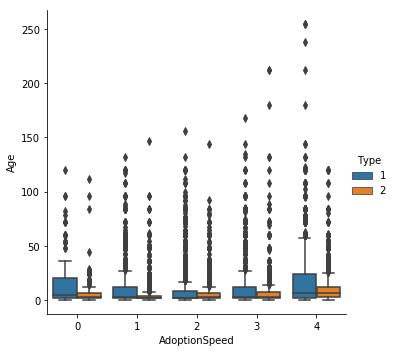

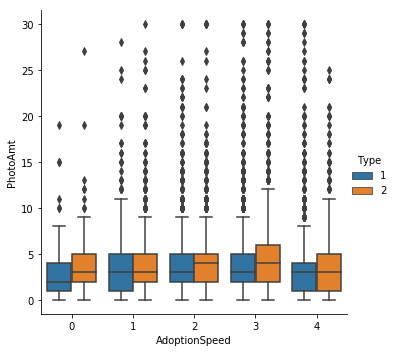

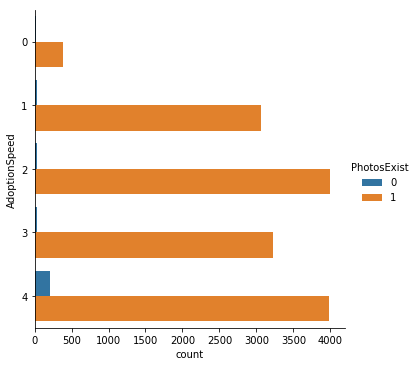

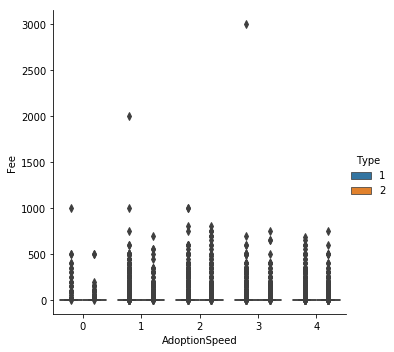

In [6]:
sns.catplot(y="Age", x="AdoptionSpeed", kind="box",  hue="Type", showfliers=True, data=df)
sns.catplot(y="PhotoAmt", x="AdoptionSpeed", kind="box",  hue="Type", data=df)
sns.catplot(y="AdoptionSpeed", kind="count", hue="PhotosExist", data=df)
sns.catplot(y="Fee", x="AdoptionSpeed", kind="box",  hue="Type", data=df)

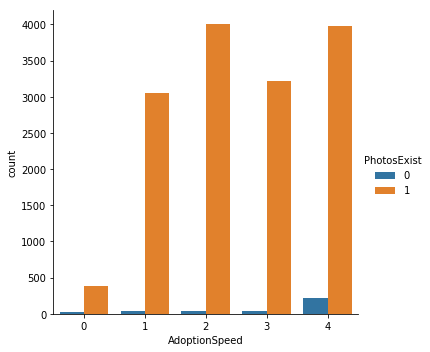

In [20]:
df['PhotosExist'] = df.apply(lambda row: 1 if row.PhotoAmt > 0 else 0, axis = 1)
sns.catplot(x="AdoptionSpeed", kind="count", hue="PhotosExist", data=df)

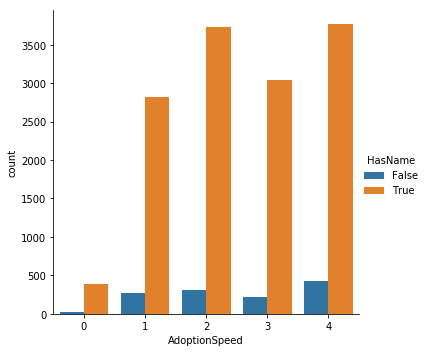

In [21]:
df['HasName'] = df.apply(lambda row: row.Name != 0, axis = 1)
sns.catplot(x="AdoptionSpeed", kind="count", hue="HasName", data=df)

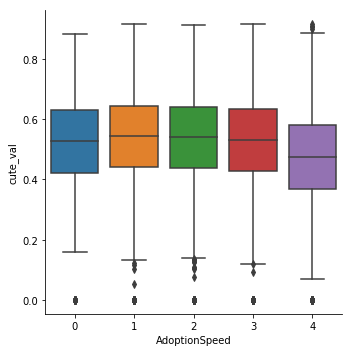

In [9]:
# cute_val was augmented from the cuteness NN (pre-ran on all examples)
sns.catplot(y="cute_val", x="AdoptionSpeed", kind="box", data=df)

In [10]:
# feature synthesis - mixed breed
def MixedBreed(row):
    if (row.Breed2 != 0):
        if (row.Breed1 != row.Breed2): return 1
    # breed number 307 is "mixed breed"
    if (row.Breed1 == 307): return 1
    return 0
df['MixedBreed'] = df.apply(MixedBreed, axis = 1)

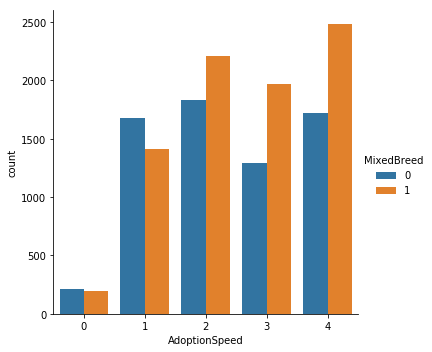

In [11]:
sns.catplot(x="AdoptionSpeed", kind="count", hue="MixedBreed", data=df)

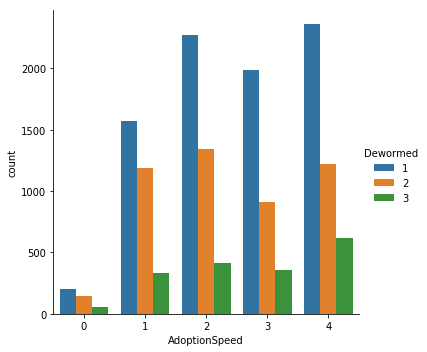

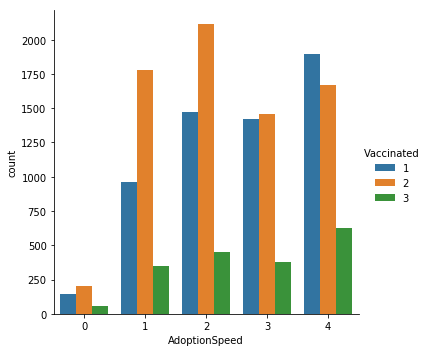

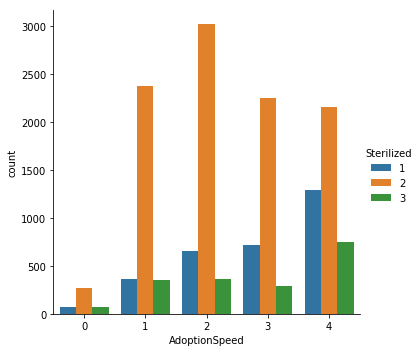

In [32]:
sns.catplot(x="AdoptionSpeed", kind="count", hue="Dewormed", data=df)
sns.catplot(x="AdoptionSpeed", kind="count", hue="Vaccinated", data=df)
sns.catplot(x="AdoptionSpeed", kind="count", hue="Sterilized", data=df)

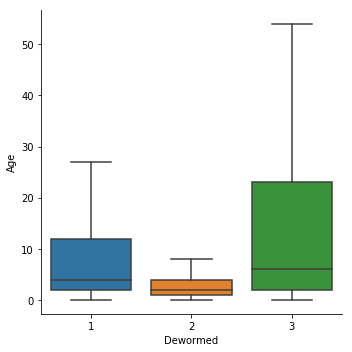

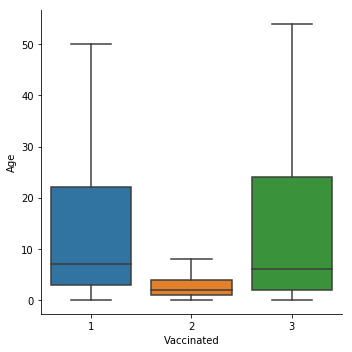

In [31]:
sns.catplot(y="Age", x="Dewormed", kind="box", showfliers=False, data=df)
sns.catplot(y="Age", x="Vaccinated", kind="box", showfliers=False, data=df)

In [13]:
def parse_sentiment_file(file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = ' '.join(file_entities)

        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()
        
        file_sentiment.update(file_sentences_sentiment)
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment

In [14]:
# merge sentiment data with pandas dataframe
train_sentiment_files = sorted(glob.glob('./Data/train_sentiment/*.json'))
count = 0
df_sentiments = None
for file in train_sentiment_files:
    with open(file, 'r',  encoding="utf8") as sf:
        json_file = json.load(sf)
        df_sentiment = parse_sentiment_file(json_file)
        df_sentiment['PetID'] = file[-14:-5]
        if df_sentiments is None:
            df_sentiments = df_sentiment
        else:
            df_sentiments = df_sentiments.append(df_sentiment)
        count = count + 1
        if (count%1000 == 0):
            print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [15]:
df = df.merge(df_sentiments, how="left", on="PetID")

In [16]:
print(df.dtypes)

Type                              int64
Name                             object
Age                               int64
Breed1                            int64
Breed2                            int64
Gender                            int64
Color1                            int64
Color2                            int64
Color3                            int64
MaturitySize                      int64
FurLength                         int64
Vaccinated                        int64
Dewormed                          int64
Sterilized                        int64
Health                            int64
Quantity                          int64
Fee                               int64
State                             int64
RescuerID                        object
VideoAmt                          int64
Description                      object
PetID                            object
PhotoAmt                        float64
AdoptionSpeed                     int64
cute_val                        float64


In [17]:
# 1-hot encoding
df['IsMale'] = df.apply(lambda row: 1 if row.Gender == 1 else 0, axis = 1)
df['IsDog'] = df.apply(lambda row: 1 if row.Type == 1 else 0, axis = 1)
df['HasName'] = df.apply(lambda row: 1 if row.HasName else 0, axis = 1)
df['IsVaccinated'] = df.apply(lambda row: 1 if row.Vaccinated == 1 else 0, axis = 1)
df['IsDewormed'] = df.apply(lambda row: 1 if row.Dewormed == 1 else 0, axis = 1)
df['IsSterilized'] = df.apply(lambda row: 1 if row.Sterilized == 1 else 0, axis = 1)


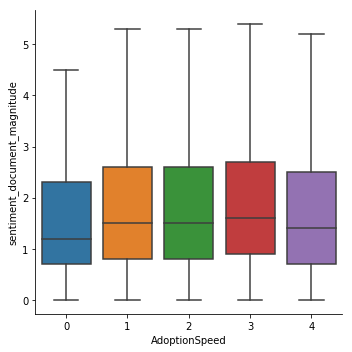

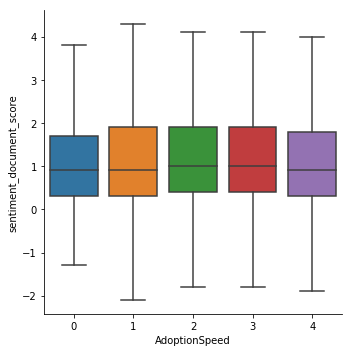

In [18]:
sns.catplot(y="sentiment_document_magnitude", x="AdoptionSpeed", kind="box", showfliers=False, data=df)
sns.catplot(y="sentiment_document_score", x="AdoptionSpeed", kind="box", showfliers=False, data=df)

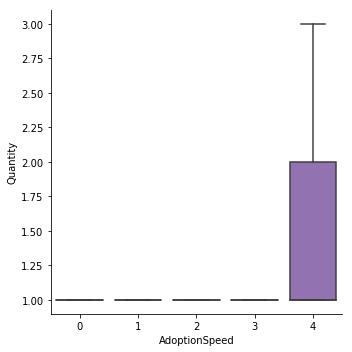

In [19]:
sns.catplot(y="Quantity", x="AdoptionSpeed", kind="box", showfliers=False, data=df)

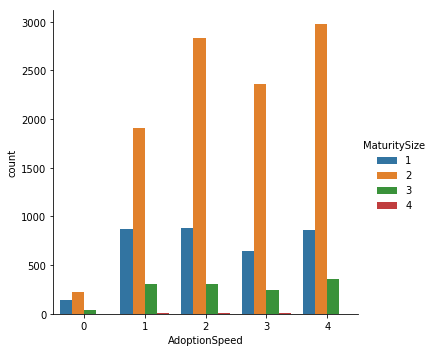

In [35]:
sns.catplot(x="AdoptionSpeed", kind="count", hue="MaturitySize", data=df)

In [41]:
# Select our features
df = df.fillna(0)
Y = df["AdoptionSpeed"].values
X_df = df[["IsDog", "Age", "IsMale", "HasName", "cute_val", "PhotoAmt",
           "IsVaccinated", "IsDewormed", "IsSterilized", "MixedBreed", "Quantity", "Health", "Fee", "PhotosExist", "sentiment_document_score", "sentiment_document_magnitude"]]
X = X_df.values
X_labels = X_df.columns.values
X_labels

array(['IsDog', 'Age', 'IsMale', 'HasName', 'cute_val', 'PhotoAmt',
       'IsVaccinated', 'IsDewormed', 'IsSterilized', 'MixedBreed',
       'Quantity', 'Health', 'Fee', 'PhotosExist',
       'sentiment_document_score', 'sentiment_document_magnitude'],
      dtype=object)

In [36]:
import scipy as sp
import numpy as np

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix

# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [37]:
from functools import partial
import numpy as np
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1, 2, 3, 4]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [42]:
from sklearn.model_selection import train_test_split, StratifiedKFold
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

num_rounds = 3000
early_stop = 500
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


param = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.0123,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
}

num_round = 2

xgb_train = xgb.DMatrix(X_train, feature_names=X_labels, label=Y_train)
xgb_test = xgb.DMatrix(X_test, feature_names=X_labels)

bst = xgb.train(param, xgb_train, num_boost_round=num_rounds)
# make prediction
pred = bst.predict(xgb_test)
print(pred)
print(Y_test)

[2.3587196 2.6882582 2.310718  ... 2.4236596 1.9805136 2.251039 ]
[1 2 3 ... 1 4 4]


In [43]:
OptR = OptimizedRounder()
OptR.fit(pred, Y_test)
print(OptR.coefficients())

def to_categorical(y):
  if y <= 1.04 :  # same day
    return 0
  elif y <= 2.22: # 1 week
    return 1
  elif y <= 2.6: # 1 month
    return 2
  elif y <= 3.93: # 1-3 months
    return 3
  else: # > 100 days
    return 4

pred = [to_categorical(y) for y in pred]

accuracy = quadratic_weighted_kappa(Y_test,pred)
print(accuracy)

[0.99577969 2.19882534 2.5488967  3.96964853]
0.2693172255059487


0.27020538810349426

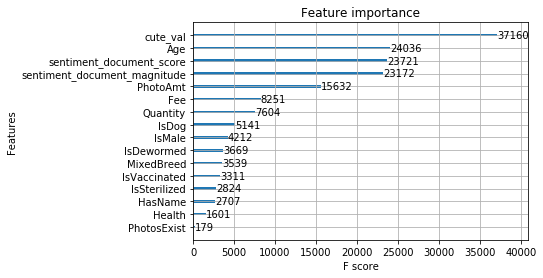

In [45]:
xgb.plot_importance(bst)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,pred)